In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
# read Datos_tratados.csv to a DataFrame
df = pd.read_csv('../Data/Datos_tratados.csv')
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,day_of_week
0,1,2020-06-09,9,0,192.0,1,0,1
1,1,2020-06-10,21,0,459.0,1,0,2
2,1,2020-06-11,15,0,438.0,1,0,3
3,1,2020-06-12,0,1,423.0,0,1,4
4,1,2020-06-13,24,1,423.0,1,0,5


In [3]:
# idSecuencia to date
df['idSecuencia'] = pd.to_datetime(df['idSecuencia'], format='%Y-%m-%d')

# add month and year columns
df['month'] = pd.DatetimeIndex(df['idSecuencia']).month
df['year'] = pd.DatetimeIndex(df['idSecuencia']).year

# add week of the year column, and day of the year column
df['week'] = pd.DatetimeIndex(df['idSecuencia']).week
df['day_of_year'] = pd.DatetimeIndex(df['idSecuencia']).dayofyear

# add quarter column
df['quarter'] = pd.DatetimeIndex(df['idSecuencia']).quarter

df.head()

C:\Users\96gar\AppData\Local\Temp\ipykernel_8936\141523002.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = pd.DatetimeIndex(df['idSecuencia']).week


,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,day_of_week,month,year,week,day_of_year,quarter
0,1,2020-06-09,9,0,192.0,1,0,1,6,2020,24,161,2
1,1,2020-06-10,21,0,459.0,1,0,2,6,2020,24,162,2
2,1,2020-06-11,15,0,438.0,1,0,3,6,2020,24,163,2
3,1,2020-06-12,0,1,423.0,0,1,4,6,2020,24,164,2
4,1,2020-06-13,24,1,423.0,1,0,5,6,2020,24,165,2


In [4]:
# add season column
def season(row):
    # if is leap year
    leap = 0
    if row['year'] % 4 == 0:
        leap = 1
    spring = range(80 + leap, 172 + leap)
    summer = range(172 + leap, 264 + leap)
    autumn = range(264 + leap, 355 + leap)

    if row['day_of_year'] in spring:
        return 'spring'
    elif row['day_of_year'] in summer:
        return 'summer'
    elif row['day_of_year'] in autumn:
        return 'autumn'
    else:
        return 'winter'

df['season'] = df.apply(season, axis=1)
df.head()


,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,day_of_week,month,year,week,day_of_year,quarter,season
0,1,2020-06-09,9,0,192.0,1,0,1,6,2020,24,161,2,spring
1,1,2020-06-10,21,0,459.0,1,0,2,6,2020,24,162,2,spring
2,1,2020-06-11,15,0,438.0,1,0,3,6,2020,24,163,2,spring
3,1,2020-06-12,0,1,423.0,0,1,4,6,2020,24,164,2,spring
4,1,2020-06-13,24,1,423.0,1,0,5,6,2020,24,165,2,spring


In [5]:
# get the first and last year of the dataset
first_year = df['year'].min()
last_year = df['year'].max()

# create a DataFrame with all the days between the first and last year
df_days = pd.DataFrame(pd.date_range(start=str(first_year) + '-01-01', end=str(last_year) + '-12-31'), columns=['idSecuencia'])

# extract yearmonth column
df_days['yearmonth'] = df_days['idSecuencia'].dt.strftime('%Y%m')
df_days['day_of_week'] = pd.DatetimeIndex(df_days['idSecuencia']).dayofweek
df_days['week'] = pd.DatetimeIndex(df_days['idSecuencia']).week
df_days['year'] = pd.DatetimeIndex(df_days['idSecuencia']).year

# concatenate he year and week columns
df_days['yearweek'] = df_days['year'].astype(str) + df_days['week'].astype(str)

# iterate over the yearmonth column
for yearmonth in df_days['yearmonth'].unique():
    # get the first day_of_week=4 of the yearmonth
    first_thursday = df_days[(df_days['yearmonth'] == yearmonth) & (df_days['day_of_week'] == 4)]['idSecuencia'].min()
    # app a column with te first thursday of the yearmonth as a flag
    df_days.loc[df_days['idSecuencia'] == first_thursday, 'first_thursday'] = 1

# get a list of the year and week of the first thursday
first_week_of_month = df_days[df_days['first_thursday'] == 1][['year','week']].values.tolist()

# concatenate the year and week of the list first_thursdays
first_week_of_month = [str(year) + str(week) for year, week in first_week_of_month]

# create a flag at df_days if the yearweek is in the list first_week_of_month
df_days['first_week_of_month'] = df_days['yearweek'].isin(first_week_of_month)

# filter the first week of the month
df_days = df_days[df_days['first_week_of_month'] == True]

# create a flag at df with 1 if the idSecuencia is in the column idSecuencia of df_days, and 0 otherwise
df['first_week_of_month'] = df['idSecuencia'].isin(df_days['idSecuencia'])
df['first_week_of_month'] = df['first_week_of_month'].replace({True: 1, False: 0})

C:\Users\96gar\AppData\Local\Temp\ipykernel_8936\3162505441.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_days['week'] = pd.DatetimeIndex(df_days['idSecuencia']).week


In [6]:
# binarize columns
df = pd.get_dummies(df, columns=['season'])
df = pd.get_dummies(df, columns=['day_of_week'])
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,season_spring,season_summer,season_winter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,1,0,0,0,1,0,0,0,0,0
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,1,0,0,0,0,1,0,0,0,0
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,1,0,0,0,0,0,1,0,0,0
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,1,0,0,0,0,0,0,1,0,0
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,1,0,0,0,0,0,0,0,1,0


Si sabemos el país o región de los datos:
- Calendario de festivos oficiales del país.
- Vacaciones escolares.
- Predicción meteorológica.
- Horas de sol esperadas en el día.
- Eventos especiales del país o región o momento: navidad, black friday, san valentín, san jordi, mundial de fútbol, final champions, olimpiadas.
- Bit: horario de invierno/verano (cambio de hora)

In [7]:
# lag of day before, for each sku of udsVenta
for i in range(1, 8):
    df['udsVenta_lag_' + str(i)] = df.groupby('idSku')['udsVenta'].shift(i)
    df['udsVenta_diff_' + str(i)] = df.groupby('idSku')['udsVenta'].transform(lambda x: x.diff(i))
df.head()


,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_lag_3,udsVenta_diff_3,udsVenta_lag_4,udsVenta_diff_4,udsVenta_lag_5,udsVenta_diff_5,udsVenta_lag_6,udsVenta_diff_6,udsVenta_lag_7,udsVenta_diff_7
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,9.0,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,21.0,3.0,9.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
periods = [2, 4, 8]
operations = ['sum', 'max', 'min', 'mean', 'median', 'std']

# add rolling operations of udsVenta for each sku
for p in periods:
    for op in operations:
        df['udsVenta_rolling_' + op + '_' + str(p)] = df.groupby('idSku')['udsVenta'].transform(lambda x: x.rolling(p).agg(op))
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,0.0,11.25,12.0,8.958236,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,0.0,15.00,18.0,10.677078,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# delte the rows with null values
df = df.dropna()
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
7,1,2020-06-16,9,1,369.0,1,0,6,2020,25,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
8,1,2020-06-17,3,1,360.0,1,0,6,2020,25,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
9,1,2020-06-18,33,1,357.0,1,0,6,2020,25,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
10,1,2020-06-19,21,1,324.0,1,0,6,2020,25,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
11,1,2020-06-20,15,1,300.0,1,0,6,2020,25,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824


C:\Users\96gar\AppData\Local\Temp\ipykernel_8936\4273801962.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')


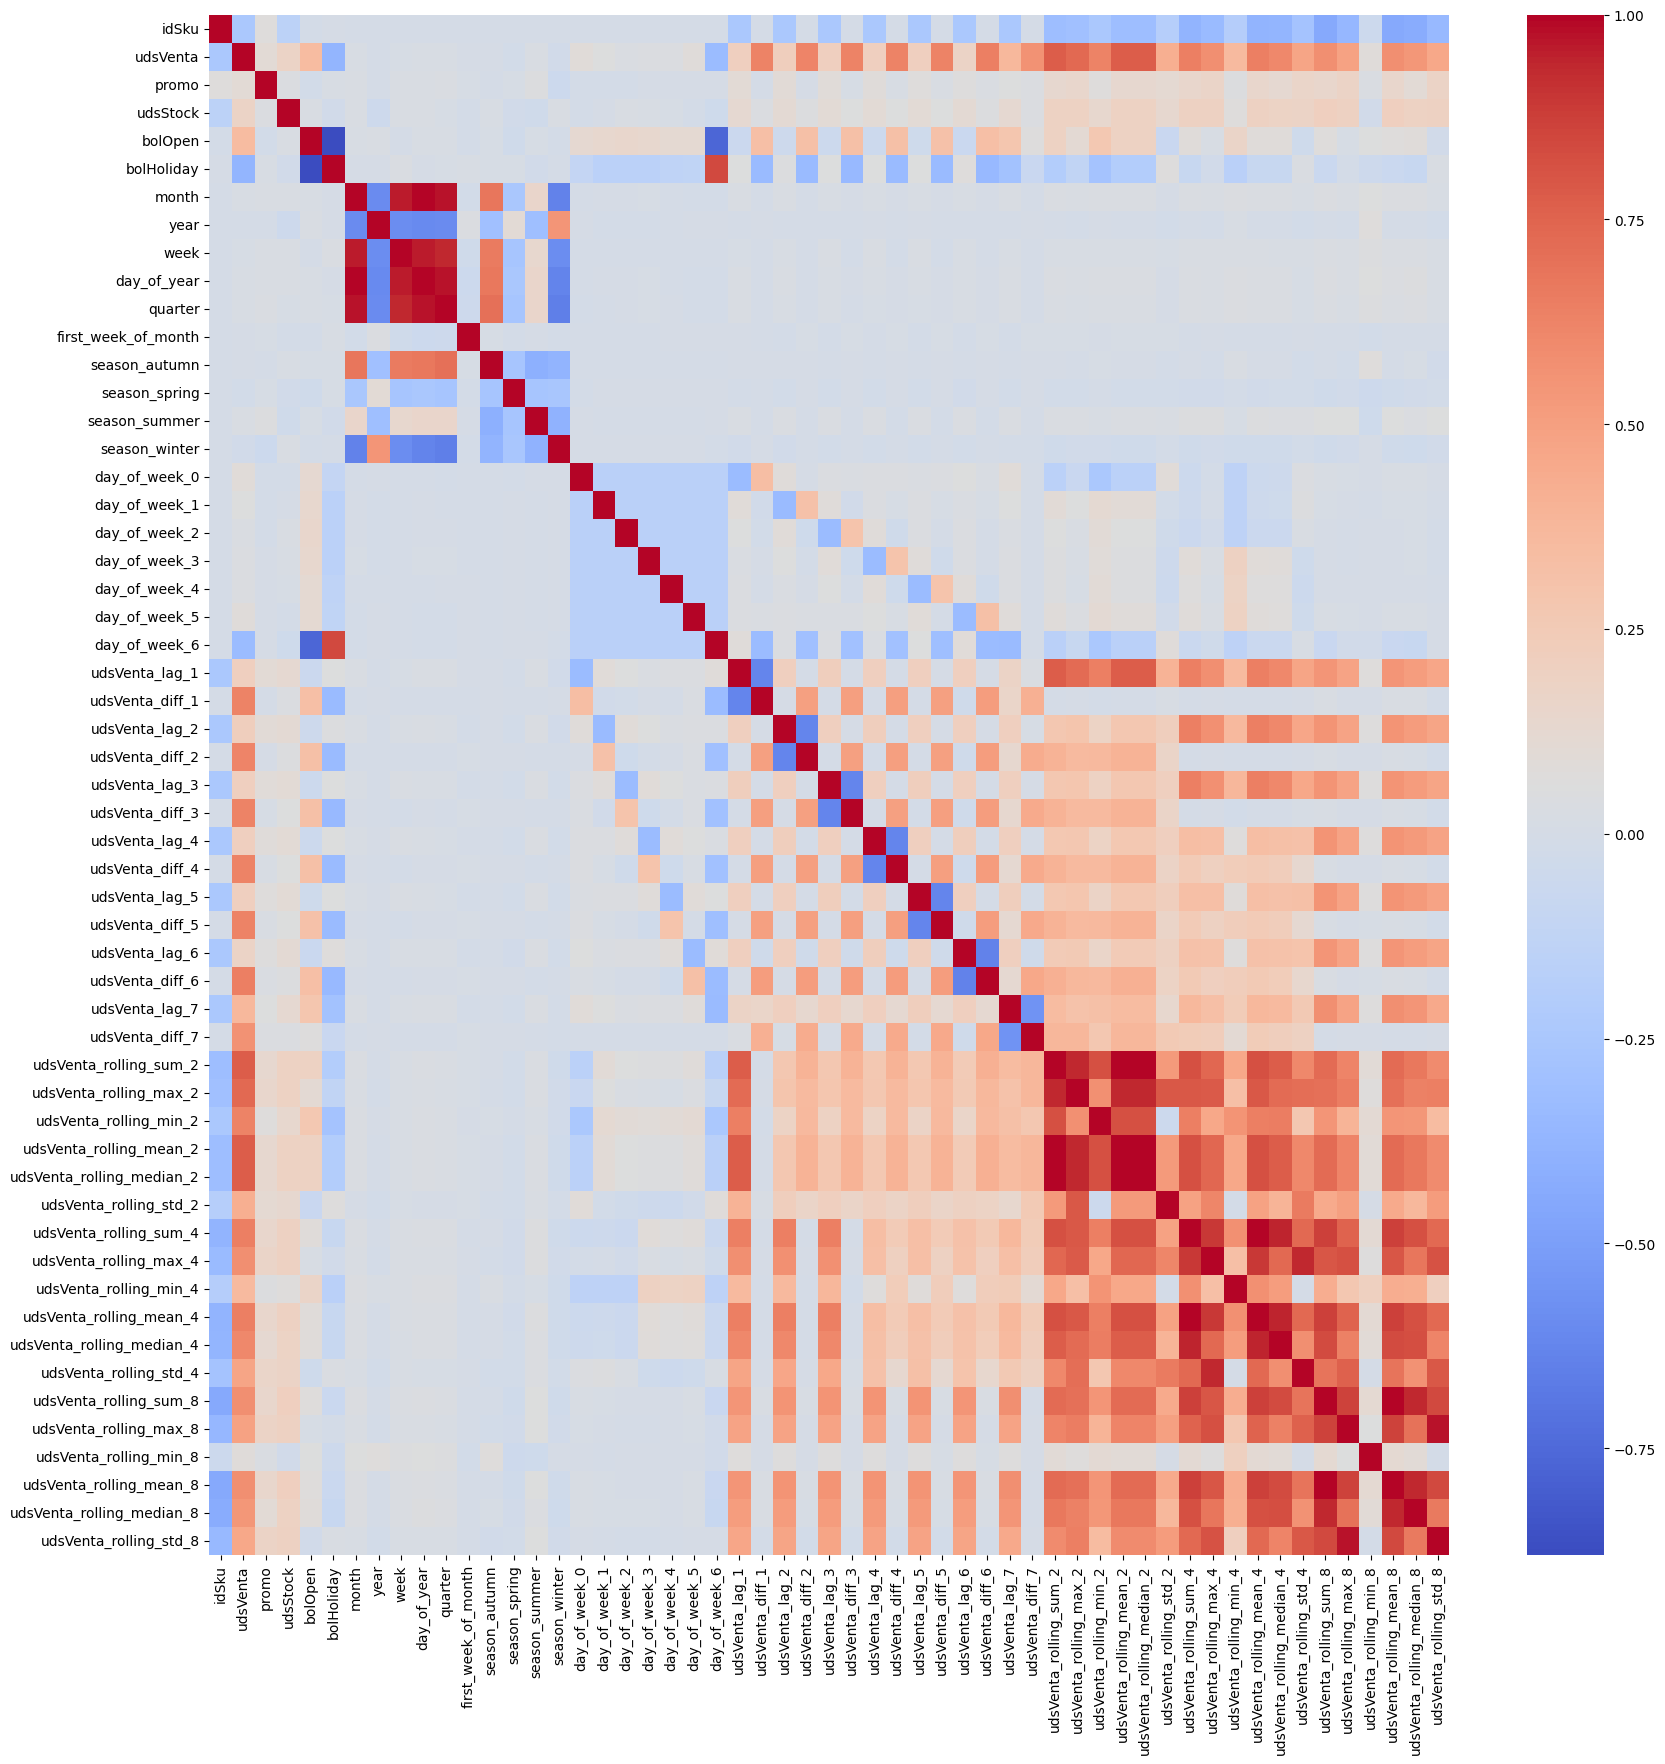

In [10]:
# heatmap of the correlation between the columns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.show()


C:\Users\96gar\AppData\Local\Temp\ipykernel_8936\3603485053.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr()[['udsVenta']].sort_values(by='udsVenta', ascending=False), annot=True, cmap='coolwarm')


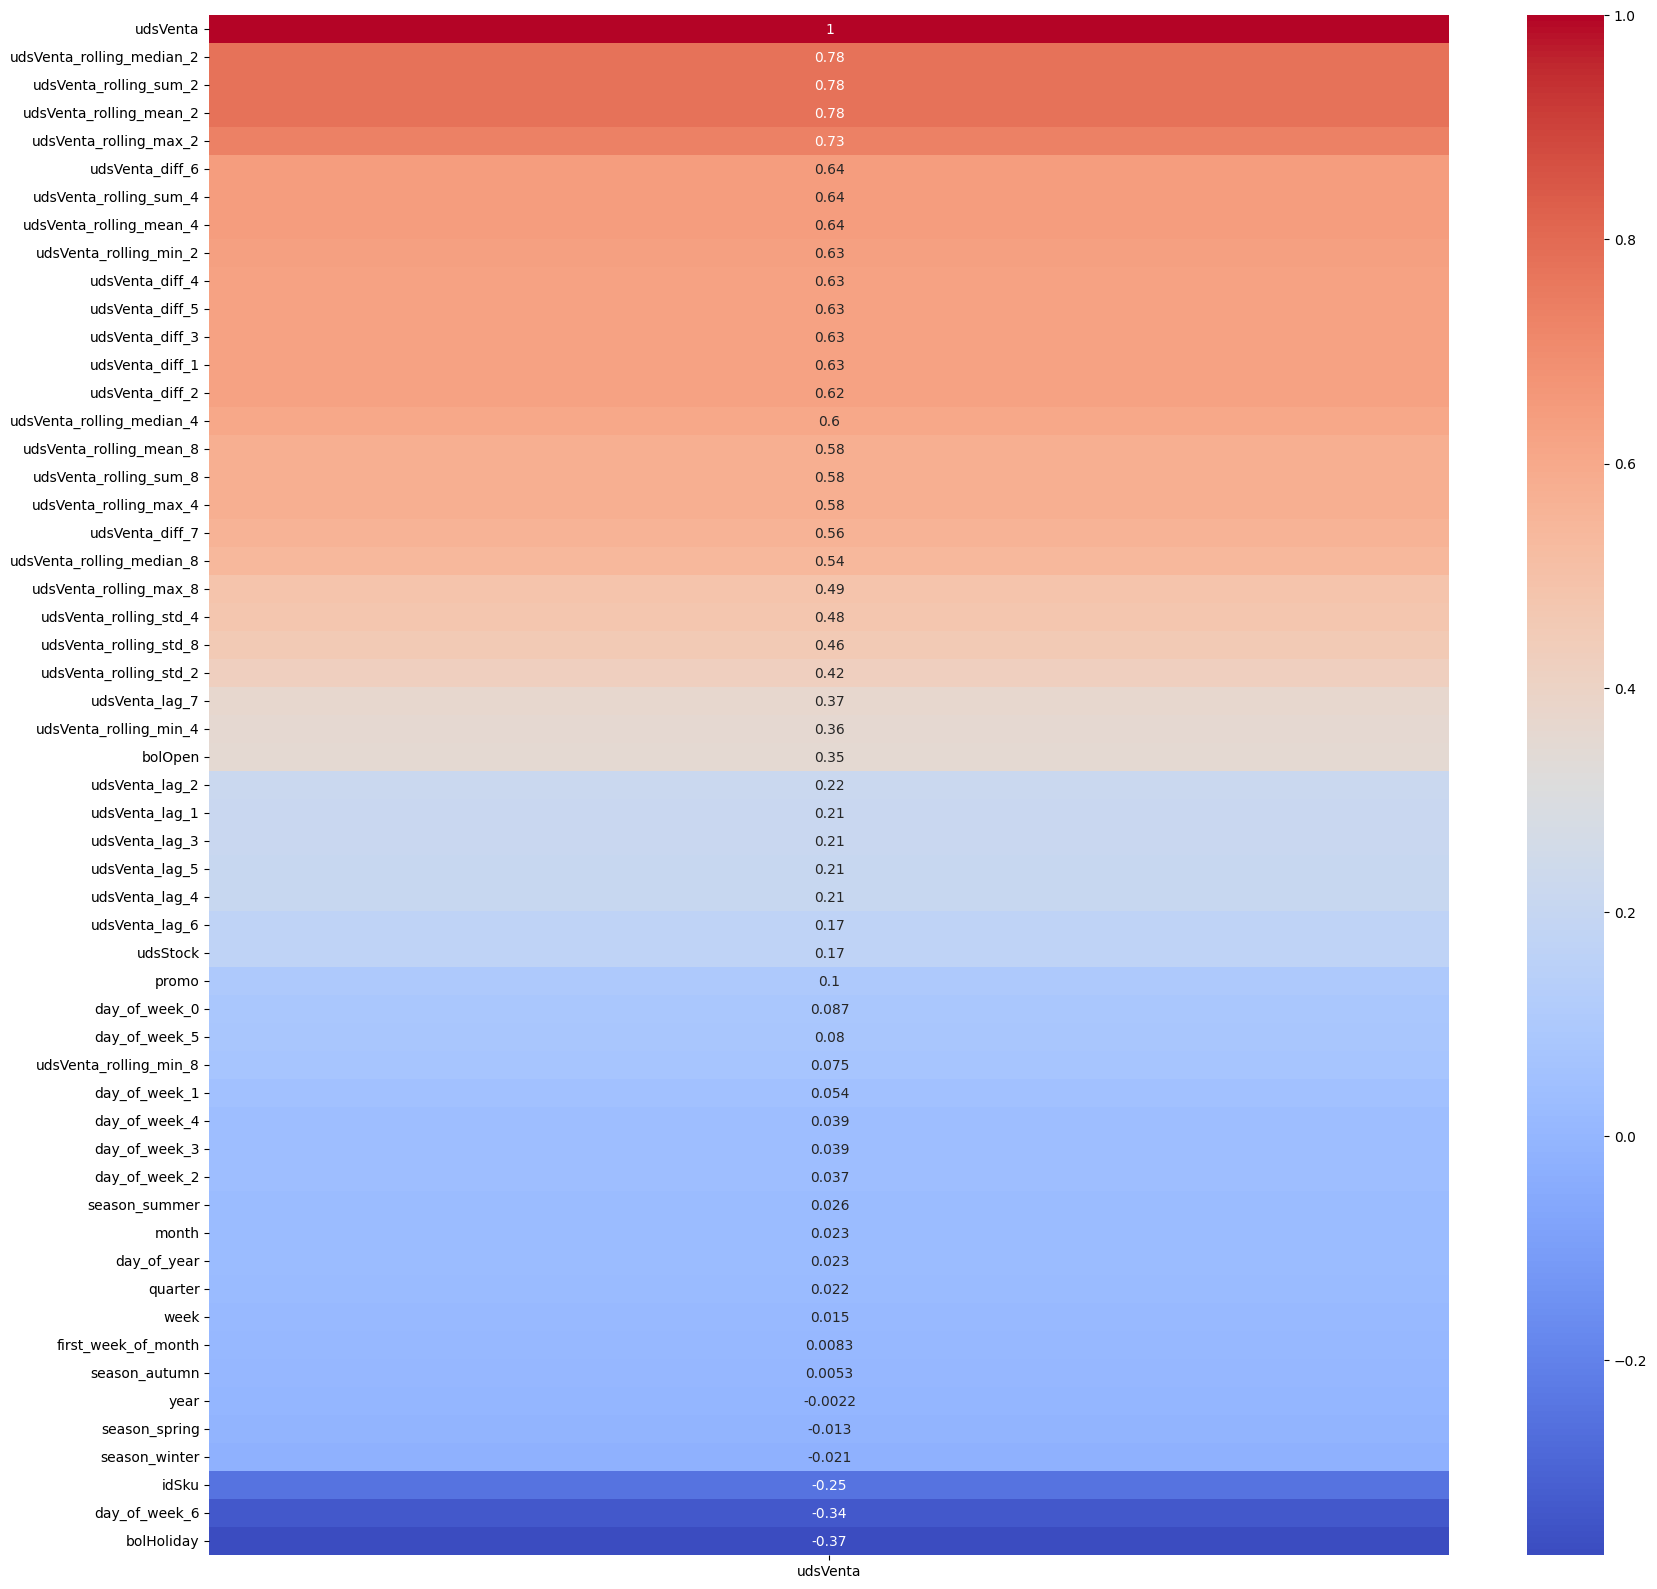

In [11]:
# heatmap of the correlation between udsVenta and the rest of columns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr()[['udsVenta']].sort_values(by='udsVenta', ascending=False), annot=True, cmap='coolwarm')
plt.show()

In [12]:
# get the correlation coefficients of udsVenta with the rest of columns, for each sku
df_corr = df.groupby('idSku').corr()['udsVenta'].reset_index()

#rename the column level_1 to variable and the column udsVenta to correlation_coefficient
df_corr = df_corr.rename(columns={'level_1': 'variable', 'udsVenta': 'correlation_coefficient'})

# select distinct variable with absolute value of correlation_coefficient > 0.3
corr_variables = df_corr[(df_corr['correlation_coefficient'].abs() > 0.3) & (df_corr['variable'] != 'udsVenta')]['variable'].unique().tolist()
print(corr_variables)

['bolOpen', 'bolHoliday', 'day_of_week_6', 'udsVenta_diff_1', 'udsVenta_diff_2', 'udsVenta_diff_3', 'udsVenta_diff_4', 'udsVenta_diff_5', 'udsVenta_diff_6', 'udsVenta_lag_7', 'udsVenta_diff_7', 'udsVenta_rolling_sum_2', 'udsVenta_rolling_max_2', 'udsVenta_rolling_min_2', 'udsVenta_rolling_mean_2', 'udsVenta_rolling_median_2', 'udsVenta_rolling_sum_4', 'udsVenta_rolling_max_4', 'udsVenta_rolling_mean_4', 'udsVenta_rolling_median_4', 'udsVenta_rolling_sum_8', 'udsVenta_rolling_max_8', 'udsVenta_rolling_mean_8', 'udsVenta_rolling_median_8', 'udsVenta_rolling_min_4', 'udsVenta_rolling_std_4', 'udsVenta_rolling_std_8', 'udsVenta_rolling_std_2', 'promo', 'udsVenta_rolling_min_8']


C:\Users\96gar\AppData\Local\Temp\ipykernel_8936\3062383567.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_corr = df.groupby('idSku').corr()['udsVenta'].reset_index()


In [13]:
# select the columns in corr_variables
df = df[['idSku', 'idSecuencia', 'udsVenta'] + corr_variables]
df.head()

,idSku,idSecuencia,udsVenta,bolOpen,bolHoliday,day_of_week_6,udsVenta_diff_1,udsVenta_diff_2,udsVenta_diff_3,udsVenta_diff_4,...,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_min_4,udsVenta_rolling_std_4,udsVenta_rolling_std_8,udsVenta_rolling_std_2,promo,udsVenta_rolling_min_8
7,1,2020-06-16,9,1,0,0,-21.0,9.0,-15.0,9.0,...,108.0,30.0,13.500,12.0,0.0,13.720423,10.993505,14.849242,1,0.0
8,1,2020-06-17,3,1,0,0,-6.0,-27.0,3.0,-21.0,...,102.0,30.0,12.750,12.0,0.0,13.527749,11.535659,4.242641,1,0.0
9,1,2020-06-18,33,1,0,0,30.0,24.0,3.0,33.0,...,114.0,33.0,14.250,12.0,3.0,14.974979,13.392429,21.213203,1,0.0
10,1,2020-06-19,21,1,0,0,-12.0,18.0,12.0,-9.0,...,120.0,33.0,15.000,15.0,3.0,13.304135,13.606721,8.485281,1,0.0
11,1,2020-06-20,15,1,0,0,-6.0,-18.0,12.0,6.0,...,135.0,33.0,16.875,18.0,3.0,12.489996,12.205824,4.242641,1,0.0


In [14]:
# create a copy of the dataset
df_norm = df.copy()

In [15]:
# normalize udsvVenta with MinMaxScaler for each sku in df_norm, and create a list with the scaler
scalers = []
for sku in df_norm['idSku'].unique():
    scaler = MinMaxScaler()
    df_norm.loc[df_norm['idSku'] == sku, 'udsVenta'] = scaler.fit_transform(df_norm.loc[df_norm['idSku'] == sku, 'udsVenta'].values.reshape(-1, 1))
    scalers.append(scaler)

df_norm


,idSku,idSecuencia,udsVenta,bolOpen,bolHoliday,day_of_week_6,udsVenta_diff_1,udsVenta_diff_2,udsVenta_diff_3,udsVenta_diff_4,...,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_min_4,udsVenta_rolling_std_4,udsVenta_rolling_std_8,udsVenta_rolling_std_2,promo,udsVenta_rolling_min_8
7,1,2020-06-16,0.107143,1,0,0,-21.0,9.0,-15.0,9.0,...,108.0,30.0,13.500,12.0,0.0,13.720423,10.993505,14.849242,1,0.0
8,1,2020-06-17,0.035714,1,0,0,-6.0,-27.0,3.0,-21.0,...,102.0,30.0,12.750,12.0,0.0,13.527749,11.535659,4.242641,1,0.0
9,1,2020-06-18,0.392857,1,0,0,30.0,24.0,3.0,33.0,...,114.0,33.0,14.250,12.0,3.0,14.974979,13.392429,21.213203,1,0.0
10,1,2020-06-19,0.250000,1,0,0,-12.0,18.0,12.0,-9.0,...,120.0,33.0,15.000,15.0,3.0,13.304135,13.606721,8.485281,1,0.0
11,1,2020-06-20,0.178571,1,0,0,-6.0,-18.0,12.0,6.0,...,135.0,33.0,16.875,18.0,3.0,12.489996,12.205824,4.242641,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32195,50,2022-03-10,0.142857,1,0,0,-12.0,0.0,0.0,3.0,...,51.0,15.0,6.375,4.5,3.0,6.000000,5.180665,8.485281,0,0.0
32196,50,2022-03-11,0.000000,1,0,0,-3.0,-15.0,-3.0,-3.0,...,45.0,15.0,5.625,3.0,0.0,6.652067,5.655276,2.121320,0,0.0
32197,50,2022-03-12,0.428571,1,0,0,9.0,6.0,-6.0,6.0,...,42.0,15.0,5.250,3.0,0.0,6.652067,5.257647,6.363961,0,0.0
32198,50,2022-03-13,0.000000,0,1,1,-9.0,0.0,-3.0,-15.0,...,33.0,15.0,4.125,3.0,0.0,4.242641,5.303301,6.363961,0,0.0


In [16]:
# get the last 20% distinct dates of the dataset
dates = df_norm['idSecuencia'].unique()

dates_train = dates[:int(len(dates)*0.8)]
dates_test = dates[int(len(dates)*0.8):]

# split the dataset in train and test
df_train = df[df['idSecuencia'].isin(dates_train)]
df_test = df[df['idSecuencia'].isin(dates_test)]

df_norm_train = df_norm[df_norm['idSecuencia'].isin(dates_train)]
df_norm_test = df_norm[df_norm['idSecuencia'].isin(dates_test)]

In [17]:
# Save the datasets in csv format

df.to_csv('../Data/Datos_enriquecidos.csv', index=False)
df_norm.to_csv('../Data/Datos_enriquecidos_norm.csv', index=False)

df_train.to_csv('../Data/train.csv', index=False)
df_test.to_csv('../Data/test.csv', index=False)

df_norm_train.to_csv('../Data/train_norm.csv', index=False)
df_norm_test.to_csv('../Data/test_norm.csv', index=False)

In [ ]:
# save scalers
for s, scaler in enumerate(scalers):
    pickle.dump(scaler, open('../Scalers/scaler_' + str(s+1) + '.pkl', 'wb'))
    